# Basic data analysis - Spectral Unmixing, KMeans, PCA, NFINDR etc.

S. Somnath<sup>1</sup>, R. K. Vasudevan<sup>2,3</sup>

* <sup>1</sup>  Advanced Data and Workflows Group
* <sup>2</sup>  Center for Nanophase Materials Sciences
* <sup>3</sup>  Institute for Functional Imaging of Materials 

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

#### In this notebook we load some spectral data, and perform basic data analysis, including:
* KMeans Clustering
* Non-negative Matrix Factorization
* Principal Component Analysis
* NFINDR

## Software Prerequisites:
* Standard distribution of ___Anaconda__ (includes numpy, scipy, matplotlib and sci-kit learn)
* __pysptools__ (will automatically be installed in the next step)
* __cvxopt__ for fully constrained least squares fitting
    * install in a terminal via __`conda install -c https://conda.anaconda.org/omnia cvxopt`__
* __pycroscopy__ : Pycroscopy has wrappers around most unmixing algorithms that allow such algorithms to be applied to arbitrarily complex, datasets. It's true capabilities are realized through the ability to seamlessly perform these analyses on any imaging dataset (regardless of origin, size, complexity) and storing the results back into the same dataset among other things

In [1]:
# Installing sotware prerequisites via the python package index:
#!pip install -U numpy matplotlib sklearn pysptools wget

#Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# Plotting and visualization:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for downloading files:
import wget
import os

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from pysptools import eea
import pysptools.abundance_maps as amp
from pysptools.eea import nfindr

# finally import pycroscopy:
import pycroscopy as px

# configure the notebook to place plots after code cells within the notebook:
%matplotlib inline

## The Data

In this example, we will work on __Band Excitation Piezoresponse Force Microscopy (BE PFM)__ data. This dataset contains a single complex-valued spectra (amplitude and phase recorded at each frequency) collected at each position on a two dimensional grid of spatial points. Thus, this three dimensional dataset has two position dimensions (X, Y) and one spectral dimension (frequency). 

Note that all statistical analysis, machine learning, spectral unmixing algorithms expect data to be formatted as two dimensional matrices (positon, spectra). Thus, we would need to collapse the two position dimensions in our dataset to a single dimension. Fortuantely, we will be using a pycroscopy format dataset which inherently collapses all position and spectroscopic dimensions to one dimension each thereby obviating any reshaping operation. 

#### Working with the specific BE-PFM dataset:
We will begin by downloading the data file from Github, followed by getting references to the dataset, ancillary data and a few necessary parameters

In [2]:
# remove any temporary h5 files
data_file_path = 'temp.h5'
if os.path.exists(data_file_path):
    os.remove(data_file_path)
    
# download the data file from Github:    
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/data/BELine_0004.h5'
_ = wget.download(url, data_file_path)

hdf = px.ioHDF5(data_file_path)
h5_file = hdf.file

print('Contents of data file:')
print('----------------------')
px.hdf_utils.print_tree(h5_file)
print('----------------------')

h5_meas_grp = h5_file['Measurement_000']

# Extracting some basic parameters:
num_rows = px.hdf_utils.get_attr(h5_meas_grp,'grid_num_rows')
num_cols = px.hdf_utils.get_attr(h5_meas_grp,'grid_num_cols')

# Getting a reference to the main dataset:
h5_main = h5_meas_grp['Channel_000/Raw_Data']

# Extracting the X axis - vector of frequencies
h5_spec_vals = px.hdf_utils.getAuxData(h5_main,'Spectroscopic_Values')[-1]
freq_vec = np.squeeze(h5_spec_vals.value) * 1E-3

print('Data currently of shape:', h5_main.shape)

x_label = 'Frequency (kHz)'
y_label = 'Amplitude (a.u.)'

Contents of data file:
----------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Bin_FFT
Measurement_000/Channel_000/Bin_Frequencies
Measurement_000/Channel_000/Bin_Indices
Measurement_000/Channel_000/Bin_Step
Measurement_000/Channel_000/Bin_Wfm_Type
Measurement_000/Channel_000/Excitation_Waveform
Measurement_000/Channel_000/Noise_Floor
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Bin_Frequencies
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Mean_Spectrogram
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Spectroscopic_Parameter
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Step_Averaged_Response
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values
Measure

No position datasets found as attributes of /Measurement_000/Channel_000/Spectroscopic_Values


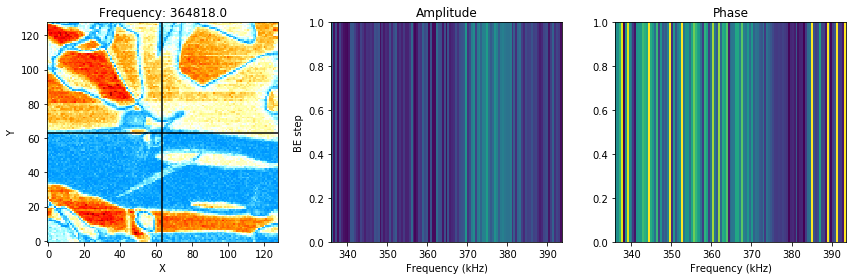

In [3]:
## Basic Visualization
px.viz.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

## 1. Singular Value Decomposition (SVD)

SVD is an eigenvector decomposition that is defined statistically, and therefore typically produces non-physical eigenvectors. Consequently, the interpretation of eigenvectors and abundance maps from SVD requires care and caution in interpretation. Nontheless, it is a good method for quickly visualizing the major trends in the dataset since the resultant eigenvectors are sorted in descending order of variance or importance. Furthermore, SVD is also very well suited for data cleaning through the reconstruction of the dataset using only the first N (most significant) components. 

SVD results in three matrices:
* V - Eigenvectors sorted by variance in descending order
* U - corresponding bundance maps
* S - Variance or importance of each of these components

### Advantage of pycroscopy: 
Notice that we are working with a complex valued dataset. Passing the complex values as is to SVD would result in complex valued eigenvectors / endmembers as well as abundance maps. Complex valued abundance maps are not physical. Thus, one would need to restructure the data such that it is real-valued only. 

One solution is to stack the real value followed by the magnitude of the imaginary component before passing to SVD. After SVD, the real-valued eigenvectors would need to be treated as the concatenation of the real and imaginary components. So, the eigenvectors would need to be restructured to get back the complex valued eigenvectors.

__Pycroscopy handles all these data transformations (both for the source dataset and the eigenvectors) automatically.__ In general, pycroscopy handles compund / complex valued datasets everywhere possible

Furthermore, while it is not discussed in this example, pycroscopy also writes back the results from SVD back to the same source h5 file including all relevant links to the source dataset and other ancillary datasets"

Performing SVD decomposition
SVD took 1.76 seconds.  Writing results to file.


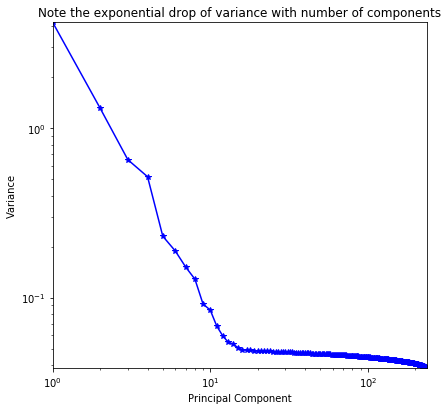

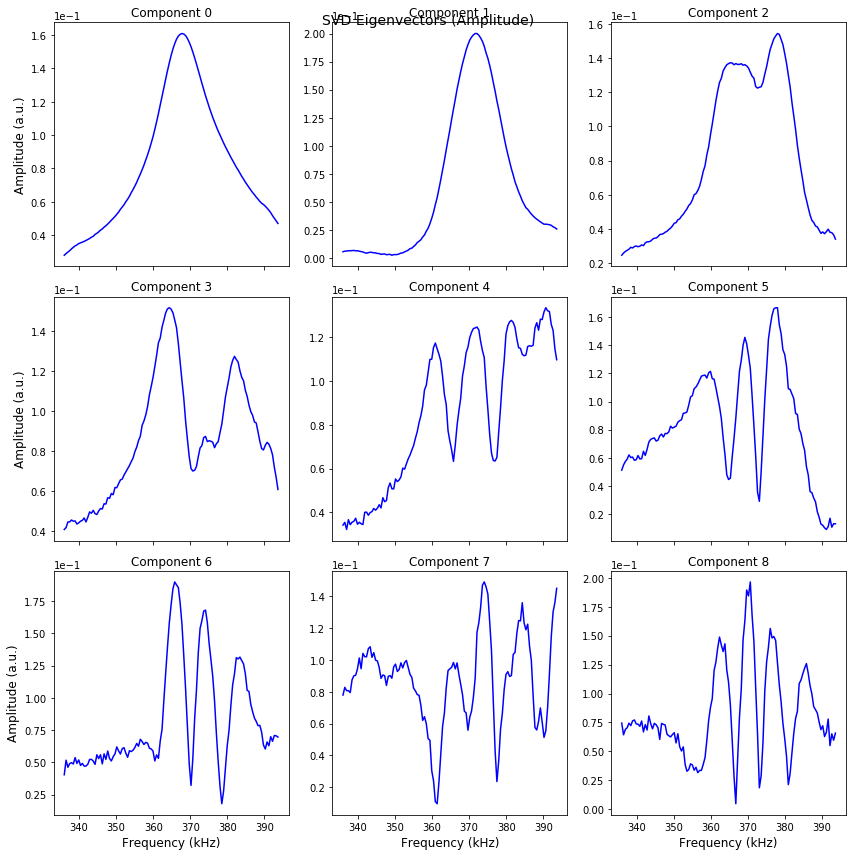

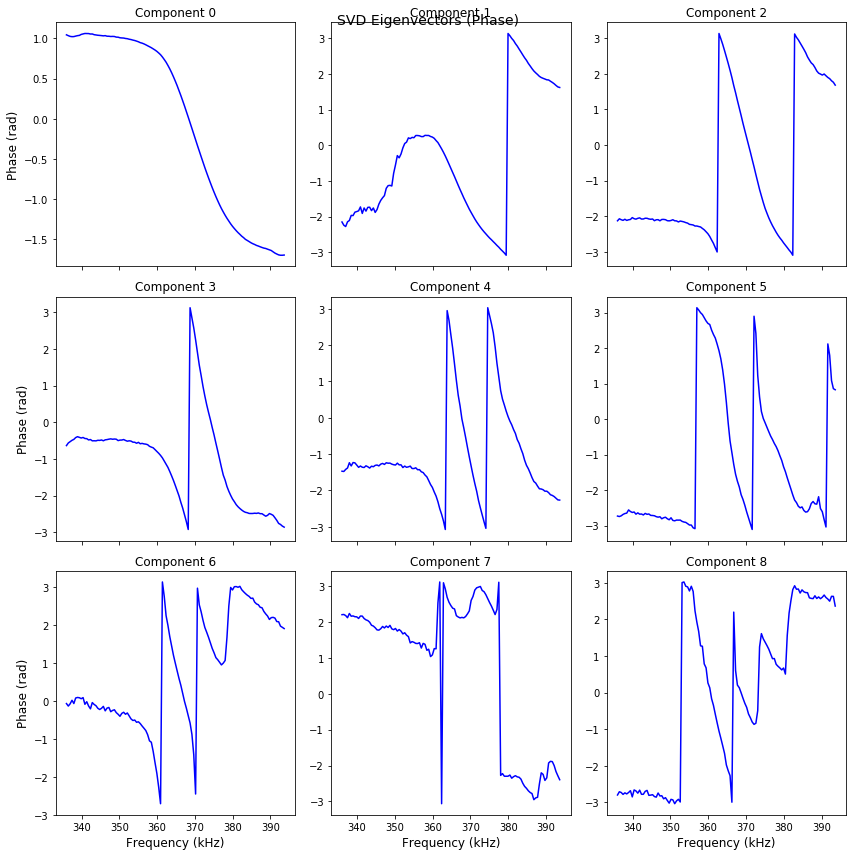

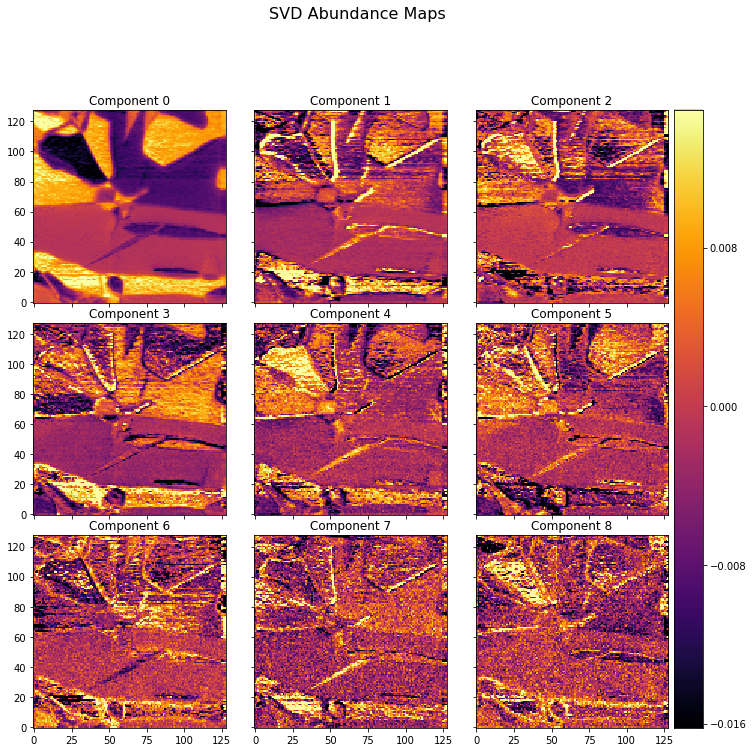

In [4]:
h5_svd_group = px.doSVD(h5_main, num_comps=256)

h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols, -1))

# Visualize the variance / statistical importance of each component:
px.plot_utils.plotScree(h5_s, title='Note the exponential drop of variance with number of components')

# Visualize the eigenvectors:
first_evecs = h5_v[:9,:]

px.plot_utils.plot_loops(freq_vec, np.abs(first_evecs), x_label=x_label, y_label=y_label, plots_on_side=3, 
                         subtitles='Component', title='SVD Eigenvectors (Amplitude)', evenly_spaced=False);
px.plot_utils.plot_loops(freq_vec, np.angle(first_evecs), x_label=x_label, y_label='Phase (rad)', plots_on_side=3, 
                         subtitles='Component', title='SVD Eigenvectors (Phase)', evenly_spaced=False);

# Visualize the abundance maps:
px.plot_utils.plot_map_stack(abun_maps, num_comps=9, heading='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno');

## 2. KMeans Clustering

KMeans clustering is a quick and easy method to determine the types of spectral responses present in the data. It is not a decomposition method, but a basic clustering method. The user inputs the number of clusters (sets) to partition the data into. The algorithm proceeds to find the optimal labeling (ie., assignment of each spectra as belonging to the k<sup>th</sup> set) such that the within-cluster sum of squares is minimized.

Set the number of clusters below

In [ ]:
num_comps = 6

estimator = px.Cluster(h5_main, 'KMeans', n_clusters=num_comps)
h5_kmeans_group = estimator.do_cluster()

h5_labels = h5_kmeans_group['Labels']
h5_centroids = h5_kmeans_group['Mean_Response']

#px.plot_utils.plot_cluster_h5_group(h5_kmeans_group)


# get the amplitude component of the dataset
"""data_mat = np.abs(h5_main)

estimators = KMeans(num_comps)
results = estimators.fit(data_mat)
labels, centroids = px.processing.cluster.reorder_clusters(results.labels_, results.cluster_centers_)

px.plot_utils.plot_cluster_results_together(np.reshape(labels, (num_rows, num_cols)), 
                                            centroids, spec_val=freq_vec, cmap=plt.cm.inferno, 
                                            spec_label=x_label, resp_label='Response')"""

Performing clustering on /Measurement_000/Channel_000/Raw_Data.


## 3. Non-negative Maxtrix Factorization (NMF)

NMF, or non-negative matrix factorization, is a method that is useful towards unmixing of spectral data. It __only__ works on data with positive real values. It operates by approximate determination of factors (matrices) W and H, given a matrix V, as shown below

![NMF](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)

Since this dataset is complex valued, it does not satisfy the non-negativity criterion. For illustrative purposes, we will use the absolute value (amplitude component) of the dataset instead

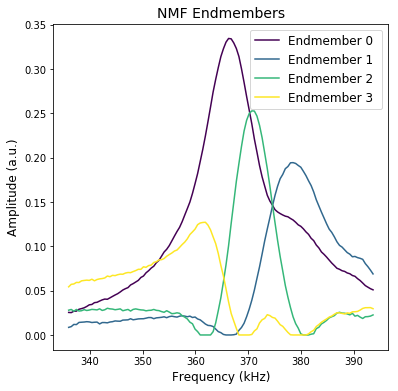

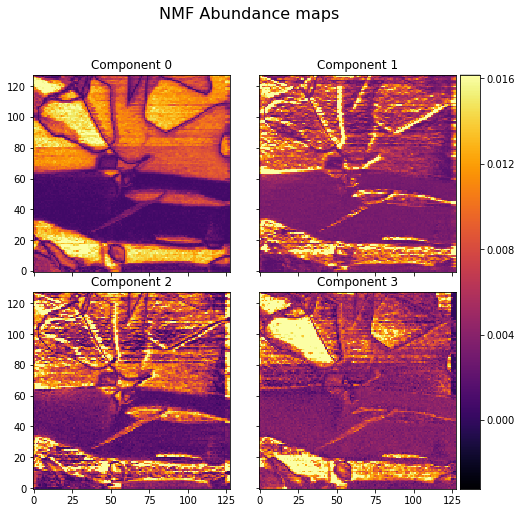

In [14]:
num_comps = 4

model = px.Decomposition(h5_main, 'NMF', n_components=num_comps)
h5_nmf_grp = model.doDecomposition()

h5_endmembers = h5_nmf_grp['Components']
h5_projections = h5_nmf_grp['Projection']

fig, axis = plt.subplots(figsize=(6, 6))
px.plot_utils.plot_line_family(axis, freq_vec, np.abs(h5_endmembers), 
                               label_prefix='Endmember')
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Endmembers', fontsize=14)
axis.legend(bbox_to_anchor=[1.0,1.0], fontsize=12);

nmf_abund_maps = np.reshape(h5_projections, (num_rows, num_cols, -1))

px.plot_utils.plot_map_stack(nmf_abund_maps, heading='NMF Abundance maps', 
                             cmap=plt.cm.inferno, color_bar_mode='single');

## 4. NFINDR

NFINDR is a geometric decomposition technique that can aid in determination of constitent spectra in data. The basic idea is as follows. Assume that at any point <i>x</i>, the spectra measured <i>A(w,x)</i> is a linear superposition of <i>k</i> 'pure' spectra, i.e.

<i>A(w,x)</i> = c<sub>0</sub>(x)a<sub>0</sub> + c<sub>1</sub>(x)a<sub>1</sub> + ... + c<sub>k</sub>(x)a<sub>k</sub>

In this case, our task consists of first determining the pure spectra {a<sub>0</sub>,...,a<sub>k</sub>}, and then determining the coefficients {c<sub>0</sub>,...,c<sub>k</sub>}. NFINDR determines the 'pure' spectra by first projecting the data into a low-dimensional sub-space (typically using PCA), and then taking the convex hull of the points in this space. Then, points are picked at random along the convex hull and the volume of the simplex that the points form is determined. If (k+1) pure spectra are needed, the data is reduced to (k) dimensions for this purpose. The points that maximize the volume of the simples are taken as the most representative pure spectra available in the dataset. One way to think of this is that any spectra that lie within the given volume can be represented as a superposition of these constituent spectra; thus maximizing this volume allows the purest spectra to be determined. 

The second task is to determine the coefficients. This is done usign the fully constrained least squares optimization, and involves the sum-to-one constraint, to allow quantitative comparisons to be made. More information can be found in the paper below:

[Winter, Michael E. "N-FINDR: An algorithm for fast autonomous spectral end-member determination in hyperspectral data." SPIE's International Symposium on Optical Science, Engineering, and Instrumentation. International Society for Optics and Photonics, 1999.](http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=994814)

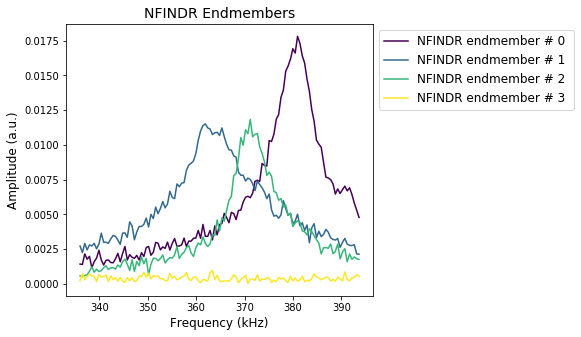

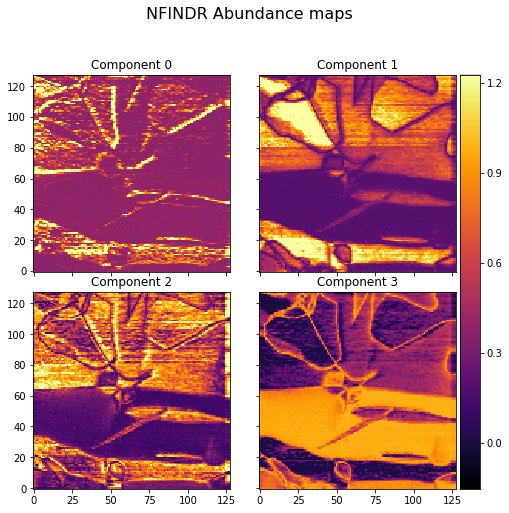

In [7]:
num_comps = 4

# get the amplitude component of the dataset
data_mat = np.abs(h5_main)

nfindr_results = eea.nfindr.NFINDR(data_mat, num_comps) #Find endmembers
end_members = nfindr_results[0]

fig, axis = plt.subplots(figsize=(5.5, 5))
px.plot_utils.plot_line_family(axis, freq_vec, end_members, label_prefix='NFINDR endmember #')
axis.set_title('NFINDR Endmembers', fontsize=14)
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.legend(bbox_to_anchor=[1.0,1.0], fontsize=12)

# fully constrained least squares model:
fcls = amp.FCLS() 
# Find abundances:
amap = fcls.map(data_mat[np.newaxis, :, :], end_members) 

# Reshaping amap
amap = np.reshape(np.squeeze(amap), (num_rows, num_cols, -1))

px.plot_utils.plot_map_stack(amap, heading='NFINDR Abundance maps', cmap=plt.cm.inferno,
                             color_bar_mode='single');

In [15]:
# Close and delete the temporarily downloaded file
hdf.close()
os.remove(data_file_path)